# Eye Tracking Data Analysis Project

This project is prepared for BDA 502 - Introduction to Machine Learning Course

Group Members:

    * YUDUM PAÇİN
    * YIĞIT ONAY 
    * EGEMEN ONAT ATAM 
    * HACI BAYRAM SAYGILI 
    * ARDA

## Table of Contents:
* [Data](#first-bullet)
* [Data Preprocess](#second-bullet)
* [Statistical Analysis](#second-bullet)
* [Machine Learning](#second-bullet)

Eye Tracking Data source, given [link](https://drive.google.com/drive/folders/1-IONyJb2HClD2KfeJtVgrsV4IMwJsd26?usp=share_link) is in csv formatted 80 files with approximately 50000 rows for each, consisting of participants of Eye Tracking Experiment.

[Eye_Tracking_Data.ipynb](http://localhost:8888/notebooks/Documents/GitHub/eye_tracking_data_project/eye_tracking_data_project/Eye_Tracking_Data.ipynb) file consists of codes we used for downloading these csv files, converting them to Pandas dataframes and saving it as pickles. 

In this file, data preprocess steps below are applied before saving the file.


* TIME, FPOGX, FPOGY, FPOGS, FPOGD, FPOGID, FPOGV, LPUPILD, LPUPILV, RPUPILD, RPUPILV, USER columns kept
* Any values that do not contain STIMULI_ONSET string under the USER column were deleted.


In these part of the analysis, we continue to data analysis of eye tracking data step by step

In [2]:
#import necessary libraries
import pickle
import bz2
import gzip
import lzma
import pickle
import numpy as np
import pandas as pd
import math
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

### emrec_data: summary of participant informations

In [3]:
#load the summary participant data
with open('emorec_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.head()

,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
0,1,28,F,control,67.600,0.970,High IAcc,0.850,0.570,0.500,0.500,2.420
1,2,28,F,self,75.600,0.750,High IAcc,0.500,0.600,0.450,0.500,2.050
2,3,25,F,self,75.000,0.700,High IAcc,1.000,0.870,0.370,0.000,2.240
3,4,26,F,self,84.300,0.910,High IAcc,0.550,0.220,0.420,0.140,1.330
4,5,30,F,self,67.300,0.810,High IAcc,0.600,0.420,0.370,0.420,1.810


In [5]:
data.shape

(80, 12)

### participants data: eye tracking experiments data of all participants

In [6]:
# open participants_compressed.pbz2
with bz2.open('participants_compressed.pbz2', 'rb') as f:
    participants = pickle.load(f)

In [7]:
participants.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2884,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2885,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2886,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2887,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e


In [8]:
participants.shape

(3409501, 13)

### sample data

In [ ]:
sample_data = pd.read_excel("Sample Analyses_507.xlsx")

In [ ]:
sample_data.head()

## Preprocess the Data

In [ ]:
# Validating if ratio of valid data is above 70% - possible exclusion of users.
data_1 = pd.pivot_table(participants, values=["FPOGV"], index=["USER","FileName"], aggfunc=[np.sum, "count"])
data_1["ratio"] = data_1["sum"] / data_1["count"]
data_1

In [43]:
# ratio of valid data, flagged as FPOGV=1, is grater than 70%, there is no USER to remove
data_1[data_1.ratio<0.7]

,sum,count,ratio
,FPOGV,FPOGV,
USER,,,


In [11]:
# Filtering with respect to non-null values of FPOGV, LPUPILV and RPUPILV

data_filtered = participants.loc[(participants["FPOGV"] == 1) & (participants["LPUPILV"] == 1) & (participants["RPUPILV"] == 1),:]

In [12]:
#get the final preprocessed data
df_prep = data_filtered.copy()

## The Butterworth low-pass filter

In [13]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 3                                               #
#                                                            #
##############################################################

from sklearn.decomposition import PCA

from scipy.signal import butter, lfilter, filtfilt

def low_pass_filter(data_table, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
    # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
    nyq = 0.5 * sampling_frequency
    cut = cutoff_frequency / nyq

    b, a = butter(order, cut, btype='low', output='ba', analog=False)
    if phase_shift:
        data_table[col + '_lowpass'] = filtfilt(b, a, data_table[col])
    else:
        data_table[col + '_lowpass'] = lfilter(b, a, data_table[col])
    return data_table

In [14]:
df_prep["max_pupild"] = df_prep[["LPUPILD", "RPUPILD"]].max(axis=1)
fs = 1000/200
cutoff = 1
df_low_pass_final = low_pass_filter(df_prep.groupby("USER").mean(),"max_pupild", fs, cutoff)[["max_pupild", "max_pupild_lowpass"]]

## Calculate z-scores

<AxesSubplot:xlabel='USER'>

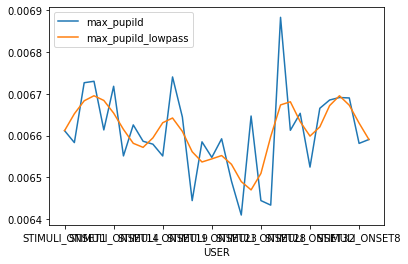

In [15]:
df_low_pass_final["z_score"] = (df_low_pass_final["max_pupild"] - np.mean(df_low_pass_final["max_pupild"])) / np.std(df_low_pass_final["max_pupild"])
df_low_pass_final[["max_pupild", "max_pupild_lowpass"]].plot()

<AxesSubplot:xlabel='USER'>

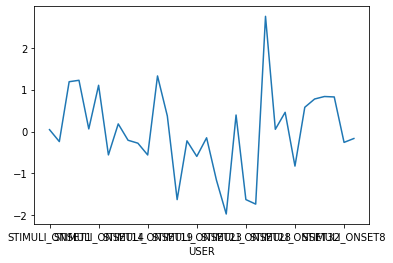

In [16]:
df_low_pass_final["z_score"].plot()


## Calculate And Add Fixation Count and Fixation Duration

In [60]:
def calculate_fixation_count(df):
    data = df.copy()

    # Specify fixation radius and minimum duration
    fixation_radius = 58
    min_duration = 0.12
    results = []

    # Get unique trial names
    trials = data['USER'].unique()
    participants = data["FileName"].unique()

    # Loop through trials and calculate fixation count and duration
    for participant in participants:
        for trial in trials:
            result = {}
            trial_data = data[data['USER'] == trial]
            fixation_count = 0
            fixation_duration = 0
            last_fixation_end_time = float('nan')
            last_x = last_y = 0

            for index, row in trial_data.iterrows():
                x = row['FPOGX'] * 1920  # Convert fraction of screen to pixels
                y = row['FPOGY'] * 1080  # Convert fraction of screen to pixels

                if math.isnan(last_fixation_end_time):
                    # First sample in trial
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = fixation_start_time
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time <= min_duration:
                    # Continuing fixation
                    pass
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time > min_duration:
                    # Extended fixation
                    fixation_duration += row['FPOGS'] - last_fixation_end_time
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) > fixation_radius:
                    # New fixation
                    fixation_count += 1
                    fixation_duration += row['FPOGD']
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']

                last_x = x
                last_y = y

            # Print results for trial
            #print(f"Trial: {trial}, Fixation Count: {fixation_count}, Fixation Duration: {fixation_duration:.2f} seconds")
            result["trial"] = trial
            result["FileName"] = participant
            result["fixation_count"] = fixation_count
            result["fixation_duration"] = fixation_duration
            results.append(result)
        
    
    return results

In [ ]:
results = calculate_fixation_count(df_prep)

In [19]:
results_df = pd.DataFrame(results)

In [20]:
df_fix = pd.merge(results_df, df_prep, left_on="trial", right_on = "USER")

In [21]:
df_fix.head()

,trial,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName,max_pupild
0,STIMULI_ONSET1,1778,894.087,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e,0.006
1,STIMULI_ONSET1,1778,894.087,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e,0.006
2,STIMULI_ONSET1,1778,894.087,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e,0.006
3,STIMULI_ONSET1,1778,894.087,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e,0.006
4,STIMULI_ONSET1,1778,894.087,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e,0.006


## Saccade Calculation

In [22]:
def calculate_saccade(df):
    data = df.copy()
    results = []

    # Get unique trial names
    trials = data['USER'].unique()
    participants = data["FileName"].unique()

    # Loop through trials and calculate saccade
    for participant in participants:
        for trial in trials:
            result = {}
            trial_data = data[data['USER'] == trial]

            delta_t = np.array(np.diff(trial_data['TIME']), dtype=np.float64) / 1000.0
            delta_x = np.array(np.diff(trial_data['FPOGX']), dtype=np.float64)
            delta_y = np.array(np.diff(trial_data['FPOGY']), dtype=np.float64)
            velocity = np.sqrt(delta_x**2 + delta_y**2) / delta_t

            # Set a velocity threshold for saccade detection
            velocity_threshold = 30.0  # degrees per second

            # Calculate saccades
            saccade = (velocity > velocity_threshold).sum()
            saccade_per_sec = saccade / (trial_data['TIME'].iloc[-1] - trial_data['TIME'].iloc[0]) * 1000.0
            result["USER"] = trial
            result["FileName"] = FileName
            result["saccade_per_sec"] = saccade_per_sec
            results.append(result)
        
    return results


In [23]:
data_saccade_ = calculate_saccade(df_fix)

In [24]:
results_df_S = pd.DataFrame(data_saccade_)

In [25]:
data_saccade = pd.merge(results_df_S, df_fix, left_on="USER", right_on = "USER")

## Statistical Analysis

1.	Participants with high vs low interoceptive awareness (ANOVA, Post-hoc, T-Tests, Correlation)

* Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, gender and accuracy scores. 

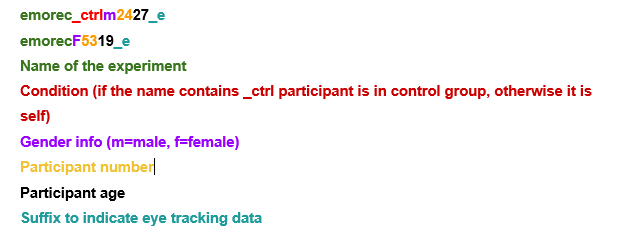

### Prepare the data for Statistical Analysis

In [26]:
data["FileName"] = "emorec" + data.apply(lambda row: "_ctrl" if row["condition"] =="control" else '', axis=1)+data.apply(lambda row: 'F' if row["subgender"]=='F' else 'm',axis=1)+data.subid.astype("str")+data.subage.astype("str")+"_e"

In [27]:
data["FileName"] = data["FileName"].str.lower()
data_saccade["FileName"] = data_saccade["FileName"].str.lower()

In [28]:
df_tam = pd.merge(data_saccade,data, left_on="FileName", right_on="FileName")

In [47]:
pd.set_option('display.max_columns', None)

In [56]:
np.unique(df_tam.subid.value_counts().index)

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72,
       73, 74, 76, 77, 78, 79, 80, 81, 82, 83], dtype=int64)

In [50]:
df_tam[df_tam.FileName=='emorecm4623_e'].sort_values(by="TIME")

,USER,saccade_per_sec,trial,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,FileName,max_pupild,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
0,STIMULI_ONSET1,1922805.688,STIMULI_ONSET1,1778,894.087,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
1,STIMULI_ONSET1,1922805.688,STIMULI_ONSET1,1778,894.087,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
2,STIMULI_ONSET1,1922805.688,STIMULI_ONSET1,1778,894.087,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
3,STIMULI_ONSET1,1922805.688,STIMULI_ONSET1,1778,894.087,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
4,STIMULI_ONSET1,1922805.688,STIMULI_ONSET1,1778,894.087,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26550,STIMULI_ONSET32,449033.293,STIMULI_ONSET32,1843,639.681,839.501,0.526,0.425,839.304,0.197,1469.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
26551,STIMULI_ONSET32,449033.293,STIMULI_ONSET32,1843,639.681,839.518,0.526,0.424,839.304,0.213,1469.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
26552,STIMULI_ONSET32,449033.293,STIMULI_ONSET32,1843,639.681,839.536,0.526,0.422,839.304,0.232,1469.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
26553,STIMULI_ONSET32,449033.293,STIMULI_ONSET32,1843,639.681,839.550,0.527,0.419,839.304,0.246,1469.000,1.000,0.006,1.000,0.006,1.000,emorecm4623_e,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210


In [45]:
df_tam.columns

Index(['USER', 'saccade_per_sec', 'trial', 'fixation_count',
       'fixation_duration', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'LPUPILD', 'LPUPILV', 'RPUPILD', 'RPUPILV',
       'FileName', 'max_pupild', 'subid', 'subage', 'subgender', 'condition',
       'heartbeats (actual) mean', 'IAcc', 'IAcc HighvsLow', 'sadnessAcc',
       'neutralAcc', 'happinessAcc', 'angerAcc', 'emorec total'],
      dtype='object')

#### Data should be in below format

In [59]:
sample_data.head()

,PARTICIPANT,GROUP (Control or self),STIMULI,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY,DURATION,FIXATION_VALIDATION,TOTAL_FIXATION_DURATION,FIXATION_DURATION_PER_COUNT,TOTAL_FIXATION_COUNT,PUPIL_DILATION,RIGHT_PUPIL_DILATION_VALIDATION,LEFT_PUPIL_DILATION_VALIDATION,TOTAL_SACCADE/SECOND
0,1,control,1,High,F,SAD,SAD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,control,2,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,control,3,High,F,ANGRY,ANGRY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,control,4,High,F,ANGRY,NEUTRAL,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,control,5,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_tam[["FileName","condition","USER", 'IAcc HighvsLow','subgender','subage']]

In [44]:
df_tam.columns

Index(['USER', 'saccade_per_sec', 'trial', 'fixation_count',
       'fixation_duration', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'LPUPILD', 'LPUPILV', 'RPUPILD', 'RPUPILV',
       'FileName', 'max_pupild', 'subid', 'subage', 'subgender', 'condition',
       'heartbeats (actual) mean', 'IAcc', 'IAcc HighvsLow', 'sadnessAcc',
       'neutralAcc', 'happinessAcc', 'angerAcc', 'emorec total'],
      dtype='object')

In [31]:
df_tam.select_dtypes("object").describe()

,USER,trial,FPOGX,FileName,subgender,condition,IAcc HighvsLow
count,2410768,2410768,2410768.000,2410768,2410768,2410768,2410768
unique,32,32,68040.000,78,2,2,2
top,STIMULI_ONSET16,STIMULI_ONSET16,0.517,emorec_ctrlf6721_e,M,self,High IAcc
freq,85334,85334,257.000,40799,1240940,1225580,1265115


<AxesSubplot:xlabel='IAcc HighvsLow', ylabel='count'>

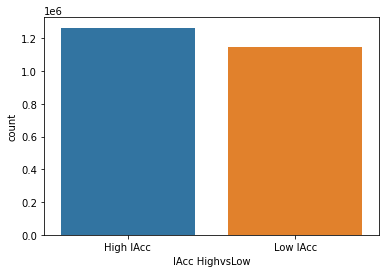

In [32]:
sns.countplot(x="IAcc HighvsLow",data=df_tam)

In [33]:
df_tam.columns

Index(['USER', 'saccade_per_sec', 'trial', 'fixation_count',
       'fixation_duration', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD',
       'FPOGID', 'FPOGV', 'LPUPILD', 'LPUPILV', 'RPUPILD', 'RPUPILV',
       'FileName', 'max_pupild', 'subid', 'subage', 'subgender', 'condition',
       'heartbeats (actual) mean', 'IAcc', 'IAcc HighvsLow', 'sadnessAcc',
       'neutralAcc', 'happinessAcc', 'angerAcc', 'emorec total'],
      dtype='object')

In [34]:
df_tam.groupby(["IAcc HighvsLow"])["fixation_count","fixation_duration","saccade_per_sec"].mean()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_3024\407366150.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["IAcc HighvsLow"])["fixation_count","fixation_duration","saccade_per_sec"].mean()


,fixation_count,fixation_duration,saccade_per_sec
IAcc HighvsLow,,,
High IAcc,1934.523,932.459,1047373.015
Low IAcc,1934.520,950.448,1048438.007


In [35]:
df_tam.groupby(["USER"])["fixation_count","fixation_duration","saccade_per_sec"].mean().T

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_3024\2226285092.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["USER"])["fixation_count","fixation_duration","saccade_per_sec"].mean().T


USER,STIMULI_ONSET1,STIMULI_ONSET10,STIMULI_ONSET11,STIMULI_ONSET12,STIMULI_ONSET13,STIMULI_ONSET14,STIMULI_ONSET15,STIMULI_ONSET16,STIMULI_ONSET17,STIMULI_ONSET18,...,STIMULI_ONSET3,STIMULI_ONSET30,STIMULI_ONSET31,STIMULI_ONSET32,STIMULI_ONSET4,STIMULI_ONSET5,STIMULI_ONSET6,STIMULI_ONSET7,STIMULI_ONSET8,STIMULI_ONSET9
fixation_count,1778.000,1669.000,1839.000,1884.000,1998.000,1854.000,1924.000,2115.000,2048.000,1932.000,...,1606.000,1988.000,1988.000,1843.000,1795.000,1686.000,1831.000,2137.000,2097.000,1811.000
fixation_duration,894.087,690.724,5694.525,712.936,761.595,751.587,775.445,904.278,848.031,1007.975,...,736.429,843.082,636.805,639.681,719.775,763.210,698.481,837.245,1020.629,748.671
saccade_per_sec,1922805.688,2294733.931,3464495.522,1361664.082,1364089.799,965896.750,1324256.222,875392.832,880829.030,626581.022,...,1124683.401,553295.661,447624.390,449033.293,1446834.192,1461617.355,1128265.911,928512.816,1288377.129,1623447.025


In [36]:
df_tam.groupby(["subgender"])["fixation_count","fixation_duration","saccade_per_sec"].mean()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_3024\2983582074.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["subgender"])["fixation_count","fixation_duration","saccade_per_sec"].mean()


,fixation_count,fixation_duration,saccade_per_sec
subgender,,,
F,1930.967,950.490,1058214.004
M,1937.872,932.069,1038136.483


In [37]:
df_tam.groupby(["IAcc HighvsLow"])["fixation_count","fixation_duration","saccade_per_sec"].mean()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_3024\407366150.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["IAcc HighvsLow"])["fixation_count","fixation_duration","saccade_per_sec"].mean()


,fixation_count,fixation_duration,saccade_per_sec
IAcc HighvsLow,,,
High IAcc,1934.523,932.459,1047373.015
Low IAcc,1934.520,950.448,1048438.007


In [38]:
korr = df_tam[["fixation_count","fixation_duration","saccade_per_sec","subage",'IAcc', 'sadnessAcc',
       'neutralAcc', 'happinessAcc', 'angerAcc']].corr(method="spearman")

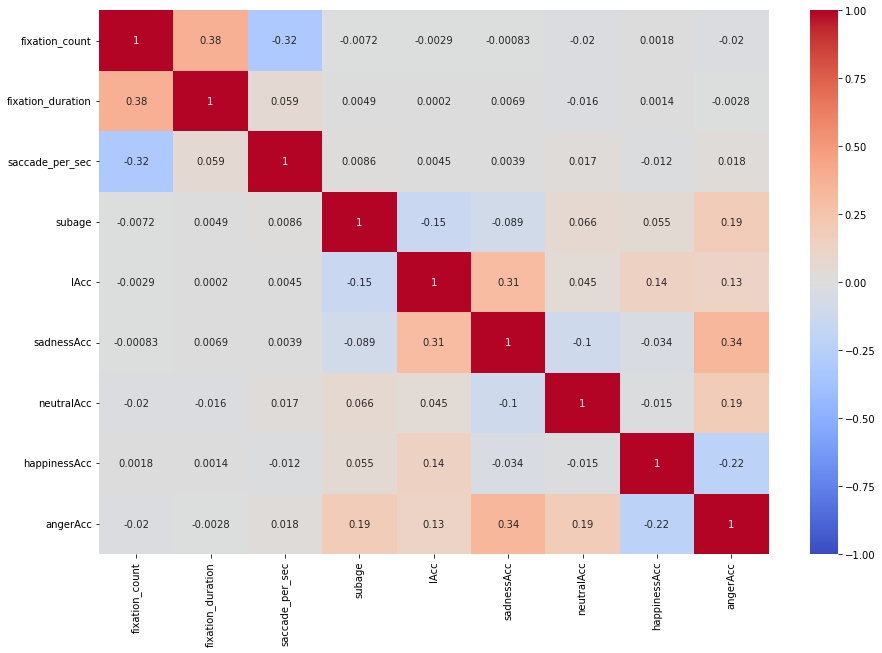

In [39]:
plt.figure(figsize = (15,10))
sns.heatmap(korr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
# Define the ANOVA model using the formula interface
model = ols('saccade_per_sec ~ condition', data=df_tam).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

                          sum_sq          df     F  PR(>F)
condition      1472725111832.030       1.000 3.616   0.057
Residual  981754949828014080.000 2410766.000   NaN     NaN


* Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for accurate trials.

2.	Main effects and interactions in terms of eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, genders and accuracy scores. (ANOVA, Post hoc, T-Tests, Correlation)

## Machine Learning